<a href="https://colab.research.google.com/github/Nishtha077/Panaroma-Stitching-Homography/blob/main/Panaromic%20Stitching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! git clone https://github.com/praveenVnktsh/Panorama-Stitching.git

Cloning into 'Panorama-Stitching'...
remote: Enumerating objects: 373, done.
remote: Counting objects: 100% (369/369), done.
remote: Compressing objects: 100% (299/299), done.
remote: Total 373 (delta 64), reused 369 (delta 64), pack-reused 4 (from 1)
Receiving objects: 100% (373/373), 575.54 MiB | 28.76 MiB/s, done.
Resolving deltas: 100% (64/64), done.


In [ ]:
import os
os.mkdir("outputs")

In [ ]:
import glob
import cv2
import numpy as np
import os
from tqdm import tqdm

In [ ]:
class Blender():
    '''
    Class that performs blending operations on images using pyramids.
    '''
    def __init__(self, depth=6):
        self.depth = depth

    def getGaussianPyramid(self, img):
        # For the image, downscale the image, and return an array.
        pyra = [img]
        for i in range(self.depth - 1):
            down = cv2.pyrDown(pyra[i])
            pyra.append(down)
        return pyra

    def getLaplacianPyramid(self, img):
        # for each image, downscale the image, and then subtract with the appropriate gaussian pyramid image to get the laplacian.
        pyra = []
        for i in range(self.depth - 1):
            nextImg = cv2.pyrDown(img)
            size = (img.shape[1], img.shape[0])
            up = cv2.pyrUp(nextImg, dstsize=size)
            sub = img.astype(float) - up.astype(float)
            pyra.append(sub)
            img = nextImg

        pyra.append(img)

        return pyra

    def getBlendingPyramid(self, lpa, lpb, gpm):
        # Blends the pyramid stages at each level according to the mask.
        pyra = []
        for i, mask in enumerate(gpm):
            maskNet = cv2.merge((mask, mask, mask))
            blended = lpa[i] * maskNet + lpb[i] * (1 - maskNet)
            pyra.append(blended)

        return pyra

    def reconstruct(self, lp):
        # for each stage in the laplacian pyramid, reconstruct by adding (inverse of what we did when downscaling)
        img = lp[-1]
        for i in range(len(lp) - 2, -1, -1):
            laplacian = lp[i]
            size = laplacian.shape[:2][::-1]

            img = cv2.pyrUp(img, dstsize=size).astype(float)
            img += laplacian.astype(float)

        return img

    def getMask(self, img):
        # gets the mask of a particular image. Simply a helper function
        mask = img[:, :, 0] != 0
        mask = np.logical_and(img[:, :, 1] != 0, mask)
        mask = np.logical_and(img[:, :, 2] != 0, mask)

        maskImg  = np.zeros(img.shape[:2], dtype=float)
        maskImg[mask] = 1.0
        return maskImg, mask

    def blend(self, img1, img2, strategy='STRAIGHTCUT'):
        '''
        Blends the two images by getting the pyramids and blending appropriately.
        '''

        # compute the required pyramids
        lp1 = self.getLaplacianPyramid(img1)
        lp2 = self.getLaplacianPyramid(img2)

        # get the masks of both images.
        _, mask1truth = self.getMask(img1)
        _, mask2truth = self.getMask(img2)

        # using the overlaps of both the images, we compute the bounding boxes.
        yi, xi = np.where(mask1truth & mask2truth)
        overlap = mask1truth & mask2truth
        tempMask = np.zeros(img1.shape[:2])
        yb, xb = np.where(overlap)

        # Initialize finalMask
        finalMask = np.zeros(img1.shape[:2])

        if xb.size > 0 and yb.size > 0:  # Check if there is an overlap
            minx = np.min(xb)
            maxx = np.max(xb)
            miny = np.min(yb)
            maxy = np.max(yb)

            if strategy == 'STRAIGHTCUT':
                # Simple strategy if there is only left -> right panning.
                finalMask[:, :(minx + maxx) // 2] = 1.0
            elif strategy == 'DIAGONAL':
                # Strategy that allows for slight variations in vertical movement also
                finalMask = cv2.fillConvexPoly(finalMask, np.array([
                    [
                        [minx, miny],
                        [maxx, maxy],
                        [maxx, img1.shape[0]],
                        [0, img1.shape[0]],
                        [0, 0],
                        [minx, 0]
                    ]
                ]), True, 50)
        else:
            print("Warning: No overlap detected between images. Using only img1 for blending.")
            finalMask = np.ones(img1.shape[:2])  # Use full mask for img1 if there's no overlap

        gpm = self.getGaussianPyramid(finalMask)

        blendPyra = self.getBlendingPyramid(lp1, lp2, gpm)

        finalImg = self.reconstruct(blendPyra)

        return finalImg, mask1truth, mask2truth


In [ ]:
def detectFeaturesAndMatch(img1, img2, nFeaturesReturn = 30):
    '''
    takes in two images, and returns a set of correspondences between the two images matched using ORB features, sorted from best to worst match using an L2 norm distance.
    '''
    orb = cv2.ORB_create()
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    kp1, des1 = orb.detectAndCompute(img1,None)
    kp2, des2 = orb.detectAndCompute(img2,None)
    matches = bf.match(des1,des2)
    matches = sorted(matches, key = lambda x:x.distance)
    correspondences = []
    for match in matches:
        correspondences.append((kp1[match.queryIdx].pt, kp2[match.trainIdx].pt))
    print('Totally', len(correspondences), 'matches')
    src = np.float32([ m[0] for m in correspondences[:nFeaturesReturn] ]).reshape(-1,1,2)
    dst = np.float32([ m[1] for m in correspondences[:nFeaturesReturn] ]).reshape(-1,1,2)
    return np.array(correspondences[:nFeaturesReturn]), src, dst

In [ ]:
def getHomography(matches):
    '''
    Takes in the points of correspondences and returns the homography matrix by
    solving for the best fit transform using SVD.
    '''
    A = np.zeros((2*len(matches), 9))
    for i, match in enumerate(matches):
        src = match[0]
        dst = match[1]
        x1 = src[0]
        x2 = dst[0]
        y1 = src[1]
        y2 = dst[1]
        A[2*i] = np.array([x1, y1, 1, 0, 0, 0, -x1*x2, -y1*x2, -x2])
        A[2*i+1] = np.array([0, 0, 0, x1, y1, 1, -x1*y2, -y1*y2, -y2])

    U, S, V = np.linalg.svd(A)
    H = np.reshape(V[-1], (3, 3) )
    return H

In [ ]:
def getBestHomographyRANSAC(matches, trials = 10000, threshold = 10, toChooseSamples = 4):
    '''
    Applies the RANSAC algorithm and tries out different homography matrices to compute the best matrix.
    '''
    finalH = None
    nMaxInliers = 0
    randomSample = None
    for trialIndex in tqdm(range(trials)):
        inliers = []
        # randomly sample from the correspondences, and then compute homography matrix
        # after finding homography, see if the number of inliers is the best so far. If yes, we take that homography.
        # the number of correspondences for which we can compute the homography is a parameter.
        randomSample = matches[np.random.choice(len(matches), size=toChooseSamples, replace=False)]
        H = getHomography(randomSample)
        for match in matches:
            src = np.append(match[0], 1).T
            dst = np.append(match[1], 1).T
            transformed = np.dot(H, src)
            transformed /= transformed[2]
            if np.linalg.norm(transformed - dst) < threshold:
                inliers.append(match)

        # best match => store
        if len(inliers) > nMaxInliers:
            nMaxInliers = len(inliers)
            finalH = H
    print('Max inliers = ', nMaxInliers)
    return finalH, randomSample

In [ ]:
def transformPoint(i, j, H):
    '''
    Helper function that simply transforms the point according to a given homography matrix
    '''
    transformed = np.dot(H, np.array([i, j, 1]))
    transformed /= transformed[2]
    transformed = transformed.astype(int)[:2]
    return np.array(transformed)

In [ ]:
def transformImage(img, H, dst, forward = False, offset = [0, 0]):
    '''
    Helper function that computes the transformed image after applying homography.
    '''
    h, w, _ = img.shape
    if forward:
        # direct conversion from image to warped image without gap filling.
        coords = np.indices((w, h)).reshape(2, -1)
        coords = np.vstack((coords, np.ones(coords.shape[1]))).astype(int)
        transformedPoints = np.dot(H, coords)
        yo, xo = coords[1, :], coords[0, :]
        # projective transform. Output's 3rd index should be one to convert to cartesian coords.
        yt = np.divide(np.array(transformedPoints[1, :]),np.array(transformedPoints[2, :])).astype(int)
        xt = np.divide(np.array(transformedPoints[0, :]),np.array(transformedPoints[2, :])).astype(int)
        dst[yt + offset[1], xt + offset[0]] = img[yo, xo]
    else:
        # applies inverse sampling to prevent any aliasing and hole effects in output image.
        Hinv = np.linalg.inv(H)
        topLeft = transformPoint(0, 0, H)
        topRight = transformPoint(w-1, 0, H)
        bottomLeft = transformPoint(0, h-1, H)
        bottomRight = transformPoint(w-1, h-1, H)
        box = np.array([topLeft, topRight, bottomLeft, bottomRight])
        minX = np.min(box[:, 0])
        maxX = np.max(box[:, 0])
        minY = np.min(box[:, 1])
        maxY = np.max(box[:, 1])
        # instead of iterating through the pixels, we take indices and do
        # H.C, where C = coordinates to get the transformed pixels.
        coords = np.indices((maxX - minX, maxY - minY)).reshape(2, -1)
        coords = np.vstack((coords, np.ones(coords.shape[1]))).astype(int)

        coords[0, :] += minX
        coords[1, :] += minY
        # here, we use the inverse transformation from the transformed bounding box to compute the pixel value of the transformed image.
        transformedPoints = np.dot(Hinv, coords)
        yo, xo = coords[1, :], coords[0, :]

        # projective transform. Output's 3rd index should be one to convert to cartesian coords.
        yt = np.divide(np.array(transformedPoints[1, :]),np.array(transformedPoints[2, :])).astype(int)
        xt = np.divide(np.array(transformedPoints[0, :]),np.array(transformedPoints[2, :])).astype(int)


        # to prevent out of range errors
        indices = np.where((yt >= 0) & (yt < h) & (xt >= 0) & (xt < w))

        xt = xt[indices]
        yt = yt[indices]

        xo = xo[indices]
        yo = yo[indices]

        # assign pixel values!
        height, width = dst.shape[:2]  # Get the dimensions of the destination image

        if (0 <= (yo + offset[1])).all() and (yo + offset[1] < height).all() and \
        (0 <= (xo + offset[0])).all() and (xo + offset[0] < width).all():
            dst[yo + offset[1], xo + offset[0]] = img[yt, xt]


In [ ]:
def execute(index1, index2, prevH, output_folder, imagePaths, imageSet, offset, shape, trials, threshold):
    '''
    Function that, for a given pair of indices, computes the best homography and saves the warped images to disk.
    '''
    warpedImage = np.zeros((4192, 8192, 3))
    img1 = cv2.imread(imagePaths[index1])
    img2 = cv2.imread(imagePaths[index2])
    # print('Original image size = ', img1.shape)
    img1 = cv2.resize(img1, shape)
    img2 = cv2.resize(img2,shape)
    matches, src, dst = detectFeaturesAndMatch(img2, img1)
    H, subsetMatches = getBestHomographyRANSAC(matches, trials = trials, threshold = threshold)
    prevH = np.dot(prevH, H)
    transformImage(img2, prevH, dst = warpedImage, offset = offset)

    cv2.imwrite('outputs/I' + str(imageSet) + '/' + output_folder + '/warped_' + str(index2) +  '.png', warpedImage)

    return prevH

In [ ]:
def main(imageSet, imagePaths, output_folder, threshold=2, trials=5000, offset=[2300, 800]):

    os.makedirs('outputs/I' + str(imageSet) + '/' + output_folder + '/', exist_ok = True)


    shape = (600, 400) # resize in order to improve speed and relax size constraints.
    # mid = len(imagePaths)//2

    threshold = 2
    trials = 5000
    offset = [2300, 800]

    prevH = np.eye(3)
    prevH = execute(2, 1, prevH, output_folder, imagePaths, imageSet, offset, shape, trials, threshold)
    prevH = np.eye(3)
    prevH = execute(1, 0, prevH, output_folder, imagePaths, imageSet, offset, shape, trials, threshold)

    prevH = np.eye(3)
    prevH = execute(2, 2, prevH, output_folder, imagePaths, imageSet, offset, shape, trials, threshold) # this is wasteful, but gets the job done.

    prevH = np.eye(3)
    prevH = execute(2, 3, prevH, output_folder, imagePaths, imageSet, offset, shape, trials, threshold)
    prevH = execute(3, 4, prevH, output_folder, imagePaths, imageSet, offset, shape, trials, threshold)

    if imageSet == 1:
        prevH = execute(4, 5, prevH, output_folder, imagePaths, imageSet, offset, shape, trials, threshold)

    b = Blender() # This blender object is written in blender.py. Its been encapsulated in a class to improve ease of use.
    finalImg =  cv2.imread('outputs/I' + str(imageSet) + '/' + output_folder + '/'  + 'warped_' + str(0) + '.png')
    if imageSet == 1:
        length = 6
    else:
        length = 5
    for index in range(1, length):
        print('blending', index)
        img2 = cv2.imread('outputs/I' + str(imageSet) + '/' + output_folder + '/' + 'warped_' + str(index) + '.png')
        # print('blending', index, 'outputs/l' + str(imageSet) + '/custom/' + 'warped_' + str(index) + '.png')
        finalImg, mask1truth, mask2truth = b.blend(finalImg, img2)
        mask1truth = mask1truth + mask2truth
        cv2.imwrite('outputs/I' + str(imageSet) + '/' + output_folder + '/' + 'FINALBLENDED.png', finalImg)


In [ ]:
imageSet = 1
imagePaths = sorted(glob.glob('/content/Panorama-Stitching/dataset/I' + str(imageSet) + '/*'))
print(imagePaths)
output_folder = 'original'
main(imageSet, imagePaths, output_folder)

['/content/Panorama-Stitching/dataset/I1/STA_0031.JPG', '/content/Panorama-Stitching/dataset/I1/STB_0032.JPG', '/content/Panorama-Stitching/dataset/I1/STC_0033.JPG', '/content/Panorama-Stitching/dataset/I1/STD_0034.JPG', '/content/Panorama-Stitching/dataset/I1/STE_0035.JPG', '/content/Panorama-Stitching/dataset/I1/STF_0036.JPG']
Totally 152 matches


100%|██████████| 5000/5000 [00:02<00:00, 1703.16it/s]


Max inliers =  19
Totally 145 matches


100%|██████████| 5000/5000 [00:02<00:00, 1745.61it/s]


Max inliers =  26
Totally 500 matches


100%|██████████| 5000/5000 [00:03<00:00, 1328.50it/s]


Max inliers =  30
Totally 150 matches


100%|██████████| 5000/5000 [00:02<00:00, 1739.03it/s]


Max inliers =  26
Totally 199 matches


100%|██████████| 5000/5000 [00:02<00:00, 1746.28it/s]


Max inliers =  28
Totally 161 matches


100%|██████████| 5000/5000 [00:03<00:00, 1363.09it/s]


Max inliers =  28
blending 1
blending 2
blending 3
blending 4
blending 5


In [ ]:
imageSet = 4
imagePaths = sorted(glob.glob('/content/Panorama-Stitching/dataset/I' + str(imageSet) + '/*'))
print(imagePaths)
output_folder = 'original'
main(imageSet, imagePaths, output_folder)

['/content/Panorama-Stitching/dataset/I4/DSC02930.JPG', '/content/Panorama-Stitching/dataset/I4/DSC02931.JPG', '/content/Panorama-Stitching/dataset/I4/DSC02932.JPG', '/content/Panorama-Stitching/dataset/I4/DSC02933.JPG', '/content/Panorama-Stitching/dataset/I4/DSC02934.JPG']
Totally 226 matches


100%|██████████| 5000/5000 [00:02<00:00, 1723.31it/s]


Max inliers =  28
Totally 208 matches


100%|██████████| 5000/5000 [00:02<00:00, 1751.82it/s]


Max inliers =  25
Totally 500 matches


100%|██████████| 5000/5000 [00:03<00:00, 1416.57it/s]


Max inliers =  30
Totally 218 matches


100%|██████████| 5000/5000 [00:02<00:00, 1726.32it/s]


Max inliers =  27
Totally 217 matches


100%|██████████| 5000/5000 [00:02<00:00, 1755.53it/s]


Max inliers =  22
blending 1
blending 2
blending 3
blending 4


In [ ]:
imageSet = 5
imagePaths = sorted(glob.glob('/content/Panorama-Stitching/dataset/I' + str(imageSet) + '/*'))
print(imagePaths)
output_folder = 'original'
main(imageSet, imagePaths, output_folder)

['/content/Panorama-Stitching/dataset/I5/DSC03002.JPG', '/content/Panorama-Stitching/dataset/I5/DSC03003.JPG', '/content/Panorama-Stitching/dataset/I5/DSC03004.JPG', '/content/Panorama-Stitching/dataset/I5/DSC03005.JPG', '/content/Panorama-Stitching/dataset/I5/DSC03006.JPG']
Totally 284 matches


100%|██████████| 5000/5000 [00:02<00:00, 1733.12it/s]


Max inliers =  29
Totally 252 matches


100%|██████████| 5000/5000 [00:03<00:00, 1320.09it/s]


Max inliers =  29
Totally 500 matches


100%|██████████| 5000/5000 [00:02<00:00, 1709.78it/s]


Max inliers =  30
Totally 280 matches


100%|██████████| 5000/5000 [00:02<00:00, 1714.65it/s]


Max inliers =  30
Totally 180 matches


100%|██████████| 5000/5000 [00:03<00:00, 1374.82it/s]


Max inliers =  29
blending 1
blending 2
blending 3
blending 4


In [ ]:
imageSet = 6
imagePaths = sorted(glob.glob('/content/Panorama-Stitching/dataset/I' + str(imageSet) + '/*'))
print(imagePaths)
output_folder = 'original'
main(imageSet, imagePaths, output_folder)

['/content/Panorama-Stitching/dataset/I6/1_0.JPG', '/content/Panorama-Stitching/dataset/I6/1_1.JPG', '/content/Panorama-Stitching/dataset/I6/1_2.JPG', '/content/Panorama-Stitching/dataset/I6/1_3.JPG', '/content/Panorama-Stitching/dataset/I6/1_4.JPG']
Totally 170 matches


100%|██████████| 5000/5000 [00:02<00:00, 1715.16it/s]


Max inliers =  26
Totally 172 matches


100%|██████████| 5000/5000 [00:04<00:00, 1217.05it/s]


Max inliers =  24
Totally 500 matches


100%|██████████| 5000/5000 [00:02<00:00, 1725.13it/s]


Max inliers =  30
Totally 245 matches


100%|██████████| 5000/5000 [00:02<00:00, 1733.28it/s]


Max inliers =  30
Totally 235 matches


100%|██████████| 5000/5000 [00:03<00:00, 1329.76it/s]


Max inliers =  30
blending 1
blending 2
blending 3
blending 4


## SIFT

In [ ]:
def detectFeaturesAndMatch(img1, img2, nFeaturesReturn=30):
    '''
    Uses SIFT for feature detection and BFMatcher for feature matching.
    '''
    # Initialize SIFT detector (using DoG)
    sift = cv2.SIFT_create()

    # Detect keypoints and descriptors
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # Brute force matcher with L2 norm (recommended for SIFT)
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

    # Match descriptors
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)

    correspondences = []
    for match in matches:
        correspondences.append((kp1[match.queryIdx].pt, kp2[match.trainIdx].pt))

    print('Totally', len(correspondences), 'matches')

    src = np.float32([m[0] for m in correspondences[:nFeaturesReturn]]).reshape(-1, 1, 2)
    dst = np.float32([m[1] for m in correspondences[:nFeaturesReturn]]).reshape(-1, 1, 2)

    return np.array(correspondences[:nFeaturesReturn]), src, dst

In [ ]:
imageSet = 1
imagePaths = sorted(glob.glob('/content/Panorama-Stitching/dataset/I' + str(imageSet) + '/*'))
print(imagePaths)
output_folder = 'sift'
main(imageSet, imagePaths, output_folder)

['/content/Panorama-Stitching/dataset/I1/STA_0031.JPG', '/content/Panorama-Stitching/dataset/I1/STB_0032.JPG', '/content/Panorama-Stitching/dataset/I1/STC_0033.JPG', '/content/Panorama-Stitching/dataset/I1/STD_0034.JPG', '/content/Panorama-Stitching/dataset/I1/STE_0035.JPG', '/content/Panorama-Stitching/dataset/I1/STF_0036.JPG']
Totally 604 matches


100%|██████████| 5000/5000 [00:03<00:00, 1636.58it/s]


Max inliers =  15
Totally 493 matches


100%|██████████| 5000/5000 [00:06<00:00, 775.67it/s]


Max inliers =  23
Totally 1614 matches


100%|██████████| 5000/5000 [00:05<00:00, 983.14it/s]


Max inliers =  30
Totally 555 matches


100%|██████████| 5000/5000 [00:07<00:00, 661.17it/s]


Max inliers =  20
Totally 507 matches


100%|██████████| 5000/5000 [00:05<00:00, 994.46it/s]


Max inliers =  27
Totally 436 matches


100%|██████████| 5000/5000 [00:05<00:00, 859.03it/s]


Max inliers =  30
blending 1
blending 2
blending 3
blending 4
blending 5


In [ ]:
imageSet = 4
imagePaths = sorted(glob.glob('/content/Panorama-Stitching/dataset/I' + str(imageSet) + '/*'))
print(imagePaths)
output_folder = 'sift'
main(imageSet, imagePaths, output_folder)

['/content/Panorama-Stitching/dataset/I4/DSC02930.JPG', '/content/Panorama-Stitching/dataset/I4/DSC02931.JPG', '/content/Panorama-Stitching/dataset/I4/DSC02932.JPG', '/content/Panorama-Stitching/dataset/I4/DSC02933.JPG', '/content/Panorama-Stitching/dataset/I4/DSC02934.JPG']
Totally 1059 matches


100%|██████████| 5000/5000 [00:02<00:00, 1675.77it/s]


Max inliers =  26
Totally 804 matches


100%|██████████| 5000/5000 [00:02<00:00, 1708.38it/s]


Max inliers =  25
Totally 2625 matches


100%|██████████| 5000/5000 [00:04<00:00, 1115.64it/s]


Max inliers =  30
Totally 1198 matches


100%|██████████| 5000/5000 [00:04<00:00, 1056.58it/s]


Max inliers =  30
Totally 1179 matches


100%|██████████| 5000/5000 [00:03<00:00, 1419.21it/s]


Max inliers =  25
blending 1
blending 2
blending 3
blending 4


In [ ]:
imageSet = 5
imagePaths = sorted(glob.glob('/content/Panorama-Stitching/dataset/I' + str(imageSet) + '/*'))
print(imagePaths)
output_folder = 'sift'
main(imageSet, imagePaths, output_folder)

['/content/Panorama-Stitching/dataset/I5/DSC03002.JPG', '/content/Panorama-Stitching/dataset/I5/DSC03003.JPG', '/content/Panorama-Stitching/dataset/I5/DSC03004.JPG', '/content/Panorama-Stitching/dataset/I5/DSC03005.JPG', '/content/Panorama-Stitching/dataset/I5/DSC03006.JPG']
Totally 753 matches


100%|██████████| 5000/5000 [00:03<00:00, 1267.52it/s]


Max inliers =  30
Totally 578 matches


100%|██████████| 5000/5000 [00:02<00:00, 1759.96it/s]


Max inliers =  24
Totally 1806 matches


100%|██████████| 5000/5000 [00:02<00:00, 1725.19it/s]


Max inliers =  30
Totally 959 matches


100%|██████████| 5000/5000 [00:03<00:00, 1515.29it/s]


Max inliers =  30
Totally 1010 matches


100%|██████████| 5000/5000 [00:02<00:00, 1739.64it/s]


Max inliers =  30
blending 1
blending 2
blending 3
blending 4


In [ ]:
imageSet = 6
imagePaths = sorted(glob.glob('/content/Panorama-Stitching/dataset/I' + str(imageSet) + '/*'))
print(imagePaths)
output_folder = 'sift'
main(imageSet, imagePaths, output_folder)

['/content/Panorama-Stitching/dataset/I6/1_0.JPG', '/content/Panorama-Stitching/dataset/I6/1_1.JPG', '/content/Panorama-Stitching/dataset/I6/1_2.JPG', '/content/Panorama-Stitching/dataset/I6/1_3.JPG', '/content/Panorama-Stitching/dataset/I6/1_4.JPG']
Totally 836 matches


100%|██████████| 5000/5000 [00:05<00:00, 869.29it/s]


Max inliers =  28
Totally 1269 matches


100%|██████████| 5000/5000 [00:07<00:00, 673.23it/s] 


Max inliers =  27
Totally 1553 matches


100%|██████████| 5000/5000 [00:05<00:00, 865.22it/s]


Max inliers =  30
Totally 556 matches


100%|██████████| 5000/5000 [00:03<00:00, 1640.80it/s]


Max inliers =  30
Totally 553 matches


100%|██████████| 5000/5000 [00:03<00:00, 1537.37it/s]


Max inliers =  30
blending 1
blending 2
blending 3
blending 4


## SIFT + Custom Patch Descriptor

In [ ]:
def extractPatchDescriptor(img, kp, patch_size=16):
    '''
    Extracts a patch descriptor for each keypoint from the image.
    '''
    descriptors = []
    for point in kp:
        x, y = int(point.pt[0]), int(point.pt[1])
        patch = img[max(0, y-patch_size//2):min(y+patch_size//2, img.shape[0]),
                    max(0, x-patch_size//2):min(x+patch_size//2, img.shape[1])]
        patch = cv2.resize(patch, (patch_size, patch_size))  # Resize to fixed size if needed
        descriptors.append(patch.flatten())  # Flatten the patch into a 1D array
    return np.array(descriptors)

In [ ]:
def detectFeaturesAndMatch(img1, img2, nFeaturesReturn=30):
    '''
    Detects features using SIFT and uses custom patch descriptors for matching.
    '''
    sift = cv2.SIFT_create()
    kp1 = sift.detect(img1, None)
    kp2 = sift.detect(img2, None)

    des1 = extractPatchDescriptor(img1, kp1)
    des2 = extractPatchDescriptor(img2, kp2)

    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)

    correspondences = [(kp1[match.queryIdx].pt, kp2[match.trainIdx].pt) for match in matches]
    print('Totally', len(correspondences), 'matches')

    src = np.float32([m[0] for m in correspondences[:nFeaturesReturn]]).reshape(-1, 1, 2)
    dst = np.float32([m[1] for m in correspondences[:nFeaturesReturn]]).reshape(-1, 1, 2)

    return np.array(correspondences[:nFeaturesReturn]), src, dst

In [ ]:
imageSet = 1
imagePaths = sorted(glob.glob('/content/Panorama-Stitching/dataset/I' + str(imageSet) + '/*'))
print(imagePaths)
output_folder = 'custom_patch'
main(imageSet, imagePaths, output_folder)

['/content/Panorama-Stitching/dataset/I1/STA_0031.JPG', '/content/Panorama-Stitching/dataset/I1/STB_0032.JPG', '/content/Panorama-Stitching/dataset/I1/STC_0033.JPG', '/content/Panorama-Stitching/dataset/I1/STD_0034.JPG', '/content/Panorama-Stitching/dataset/I1/STE_0035.JPG', '/content/Panorama-Stitching/dataset/I1/STF_0036.JPG']
Totally 292 matches


100%|██████████| 5000/5000 [00:02<00:00, 1723.76it/s]


Max inliers =  10
Totally 220 matches


100%|██████████| 5000/5000 [00:02<00:00, 1728.91it/s]


Max inliers =  24
Totally 1348 matches


100%|██████████| 5000/5000 [00:03<00:00, 1470.64it/s]


Max inliers =  30
Totally 273 matches


100%|██████████| 5000/5000 [00:02<00:00, 1731.71it/s]


Max inliers =  18
Totally 305 matches


100%|██████████| 5000/5000 [00:04<00:00, 1189.57it/s]


Max inliers =  22
Totally 217 matches


100%|██████████| 5000/5000 [00:02<00:00, 1724.98it/s]


Max inliers =  20
blending 1
blending 2
blending 3
blending 4
blending 5


In [ ]:
imageSet = 4
imagePaths = sorted(glob.glob('/content/Panorama-Stitching/dataset/I' + str(imageSet) + '/*'))
print(imagePaths)
output_folder = 'custom_patch'
main(imageSet, imagePaths, output_folder)

['/content/Panorama-Stitching/dataset/I4/DSC02930.JPG', '/content/Panorama-Stitching/dataset/I4/DSC02931.JPG', '/content/Panorama-Stitching/dataset/I4/DSC02932.JPG', '/content/Panorama-Stitching/dataset/I4/DSC02933.JPG', '/content/Panorama-Stitching/dataset/I4/DSC02934.JPG']
Totally 606 matches


100%|██████████| 5000/5000 [00:02<00:00, 1721.89it/s]


Max inliers =  24
Totally 239 matches


100%|██████████| 5000/5000 [00:02<00:00, 1764.60it/s]


Max inliers =  15
Totally 2122 matches


100%|██████████| 5000/5000 [00:02<00:00, 1730.68it/s]


Max inliers =  30
Totally 624 matches


100%|██████████| 5000/5000 [00:02<00:00, 1740.33it/s]


Max inliers =  26
Totally 350 matches


100%|██████████| 5000/5000 [00:03<00:00, 1548.45it/s]


Max inliers =  20
blending 1
blending 2
blending 3
blending 4


In [ ]:
imageSet = 5
imagePaths = sorted(glob.glob('/content/Panorama-Stitching/dataset/I' + str(imageSet) + '/*'))
print(imagePaths)
output_folder = 'custom_patch'
main(imageSet, imagePaths, output_folder)

['/content/Panorama-Stitching/dataset/I5/DSC03002.JPG', '/content/Panorama-Stitching/dataset/I5/DSC03003.JPG', '/content/Panorama-Stitching/dataset/I5/DSC03004.JPG', '/content/Panorama-Stitching/dataset/I5/DSC03005.JPG', '/content/Panorama-Stitching/dataset/I5/DSC03006.JPG']
Totally 439 matches


100%|██████████| 5000/5000 [00:03<00:00, 1253.54it/s]


Max inliers =  21
Totally 361 matches


100%|██████████| 5000/5000 [00:02<00:00, 1732.31it/s]


Max inliers =  18
Totally 1471 matches


100%|██████████| 5000/5000 [00:03<00:00, 1638.48it/s]


Max inliers =  30
Totally 309 matches


100%|██████████| 5000/5000 [00:04<00:00, 1208.28it/s]


Max inliers =  5
Totally 541 matches


100%|██████████| 5000/5000 [00:04<00:00, 1249.07it/s]


Max inliers =  30
blending 1
blending 2
blending 3
blending 4


In [ ]:
imageSet = 6
imagePaths = sorted(glob.glob('/content/Panorama-Stitching/dataset/I' + str(imageSet) + '/*'))
print(imagePaths)
output_folder = 'custom_patch'
main(imageSet, imagePaths, output_folder)

['/content/Panorama-Stitching/dataset/I6/1_0.JPG', '/content/Panorama-Stitching/dataset/I6/1_1.JPG', '/content/Panorama-Stitching/dataset/I6/1_2.JPG', '/content/Panorama-Stitching/dataset/I6/1_3.JPG', '/content/Panorama-Stitching/dataset/I6/1_4.JPG']
Totally 135 matches


100%|██████████| 5000/5000 [00:03<00:00, 1461.64it/s]


Max inliers =  5
Totally 667 matches


100%|██████████| 5000/5000 [00:02<00:00, 1694.81it/s]


Max inliers =  27
Totally 1287 matches


100%|██████████| 5000/5000 [00:03<00:00, 1345.15it/s]


Max inliers =  30
Totally 198 matches


100%|██████████| 5000/5000 [00:02<00:00, 1674.43it/s]


Max inliers =  5
Totally 302 matches


100%|██████████| 5000/5000 [00:04<00:00, 1205.88it/s]


Max inliers =  27
blending 1
blending 2
blending 3
blending 4


## NNDR

In [ ]:
from scipy.spatial import KDTree

def detectFeaturesAndMatch(img1, img2, nFeaturesReturn=30, ratio_thresh=0.75):
    '''
    Detects features using SIFT and uses KDTree for nearest neighbor search with NNDR for matching.
    '''

    sift = cv2.SIFT_create()
    kp1 = sift.detect(img1, None)
    kp2 = sift.detect(img2, None)

    des1 = extractPatchDescriptor(img1, kp1)
    des2 = extractPatchDescriptor(img2, kp2)

    # Build KD Tree for fast nearest neighbor search on des2
    kd_tree = KDTree(des2)

    # Find nearest and second nearest neighbors
    correspondences = []
    for i, descriptor in enumerate(des1):
        # Query the two nearest neighbors
        dists, idxs = kd_tree.query(descriptor, k=2)

        # Apply NNDR (Nearest Neighbor Distance Ratio)
        if dists[0] < ratio_thresh * dists[1]:
            # If the distance ratio is below the threshold, consider this a valid match
            pt1 = kp1[i].pt
            pt2 = kp2[idxs[0]].pt
            correspondences.append((pt1, pt2))

    print('Totally', len(correspondences), 'matches after NNDR filtering')

    # Sort matches by distance and return top nFeaturesReturn
    correspondences = sorted(correspondences, key=lambda x: np.linalg.norm(np.array(x[0]) - np.array(x[1])))

    src = np.float32([m[0] for m in correspondences[:nFeaturesReturn]]).reshape(-1, 1, 2)
    dst = np.float32([m[1] for m in correspondences[:nFeaturesReturn]]).reshape(-1, 1, 2)

    return np.array(correspondences[:nFeaturesReturn]), src, dst


In [ ]:
imageSet = 1
imagePaths = sorted(glob.glob('/content/Panorama-Stitching/dataset/I' + str(imageSet) + '/*'))
print(imagePaths)
output_folder = 'nndr'
main(imageSet, imagePaths, output_folder)

['/content/Panorama-Stitching/dataset/I1/STA_0031.JPG', '/content/Panorama-Stitching/dataset/I1/STB_0032.JPG', '/content/Panorama-Stitching/dataset/I1/STC_0033.JPG', '/content/Panorama-Stitching/dataset/I1/STD_0034.JPG', '/content/Panorama-Stitching/dataset/I1/STE_0035.JPG', '/content/Panorama-Stitching/dataset/I1/STF_0036.JPG']
Totally 107 matches after NNDR filtering


100%|██████████| 5000/5000 [00:02<00:00, 1724.92it/s]


Max inliers =  9
Totally 115 matches after NNDR filtering


100%|██████████| 5000/5000 [00:03<00:00, 1282.03it/s]


Max inliers =  17
Totally 1105 matches after NNDR filtering


100%|██████████| 5000/5000 [00:02<00:00, 1730.17it/s]


Max inliers =  30
Totally 110 matches after NNDR filtering


100%|██████████| 5000/5000 [00:03<00:00, 1552.25it/s]


Max inliers =  9
Totally 164 matches after NNDR filtering


100%|██████████| 5000/5000 [00:02<00:00, 1738.36it/s]


Max inliers =  11
Totally 121 matches after NNDR filtering


100%|██████████| 5000/5000 [00:03<00:00, 1411.84it/s]


Max inliers =  15
blending 1
blending 2
blending 3
blending 4
blending 5


In [ ]:
imageSet = 4
imagePaths = sorted(glob.glob('/content/Panorama-Stitching/dataset/I' + str(imageSet) + '/*'))
print(imagePaths)
output_folder = 'nndr'
main(imageSet, imagePaths, output_folder)

['/content/Panorama-Stitching/dataset/I4/DSC02930.JPG', '/content/Panorama-Stitching/dataset/I4/DSC02931.JPG', '/content/Panorama-Stitching/dataset/I4/DSC02932.JPG', '/content/Panorama-Stitching/dataset/I4/DSC02933.JPG', '/content/Panorama-Stitching/dataset/I4/DSC02934.JPG']
Totally 284 matches after NNDR filtering


  8%|▊         | 407/5000 [00:00<00:04, 994.59it/s]<ipython-input-20-5ee614ae2d1c>:19: RuntimeWarning: divide by zero encountered in divide
  transformed /= transformed[2]
<ipython-input-20-5ee614ae2d1c>:19: RuntimeWarning: invalid value encountered in divide
  transformed /= transformed[2]
100%|██████████| 5000/5000 [00:05<00:00, 967.31it/s] 


Max inliers =  20
Totally 44 matches after NNDR filtering


100%|██████████| 5000/5000 [00:03<00:00, 1403.74it/s]


Max inliers =  21
Totally 1665 matches after NNDR filtering


100%|██████████| 5000/5000 [00:02<00:00, 1702.83it/s]


Max inliers =  30
Totally 221 matches after NNDR filtering


100%|██████████| 5000/5000 [00:02<00:00, 1675.39it/s]


Max inliers =  29
Totally 105 matches after NNDR filtering


100%|██████████| 5000/5000 [00:03<00:00, 1273.30it/s]


Max inliers =  29
blending 1
blending 2
blending 3
blending 4


In [ ]:
imageSet = 5
imagePaths = sorted(glob.glob('/content/Panorama-Stitching/dataset/I' + str(imageSet) + '/*'))
print(imagePaths)
output_folder = 'nndr'
main(imageSet, imagePaths, output_folder)

['/content/Panorama-Stitching/dataset/I5/DSC03002.JPG', '/content/Panorama-Stitching/dataset/I5/DSC03003.JPG', '/content/Panorama-Stitching/dataset/I5/DSC03004.JPG', '/content/Panorama-Stitching/dataset/I5/DSC03005.JPG', '/content/Panorama-Stitching/dataset/I5/DSC03006.JPG']
Totally 154 matches after NNDR filtering


100%|██████████| 5000/5000 [00:02<00:00, 1722.06it/s]


Max inliers =  29
Totally 143 matches after NNDR filtering


100%|██████████| 5000/5000 [00:03<00:00, 1601.86it/s]


Max inliers =  15
Totally 1176 matches after NNDR filtering


100%|██████████| 5000/5000 [00:02<00:00, 1721.07it/s]


Max inliers =  30
Totally 89 matches after NNDR filtering


100%|██████████| 5000/5000 [00:03<00:00, 1270.81it/s]


Max inliers =  26
Totally 205 matches after NNDR filtering


100%|██████████| 5000/5000 [00:04<00:00, 1223.63it/s]


Max inliers =  29
blending 1
blending 2
blending 3
blending 4


In [ ]:
imageSet = 6
imagePaths = sorted(glob.glob('/content/Panorama-Stitching/dataset/I' + str(imageSet) + '/*'))
print(imagePaths)
output_folder = 'nndr'
main(imageSet, imagePaths, output_folder)

['/content/Panorama-Stitching/dataset/I6/1_0.JPG', '/content/Panorama-Stitching/dataset/I6/1_1.JPG', '/content/Panorama-Stitching/dataset/I6/1_2.JPG', '/content/Panorama-Stitching/dataset/I6/1_3.JPG', '/content/Panorama-Stitching/dataset/I6/1_4.JPG']
Totally 4 matches after NNDR filtering


100%|██████████| 5000/5000 [00:01<00:00, 3191.72it/s]


Max inliers =  4
Totally 287 matches after NNDR filtering


100%|██████████| 5000/5000 [00:03<00:00, 1254.21it/s]


Max inliers =  28
Totally 1038 matches after NNDR filtering


100%|██████████| 5000/5000 [00:02<00:00, 1689.44it/s]


Max inliers =  30
Totally 45 matches after NNDR filtering


100%|██████████| 5000/5000 [00:04<00:00, 1189.32it/s]


Max inliers =  27
Totally 198 matches after NNDR filtering


100%|██████████| 5000/5000 [00:02<00:00, 1729.74it/s]


Max inliers =  24
blending 1
blending 2
blending 3
blending 4


## Geometric Minimization

In [ ]:
def geometricMinimization(matches, initialH, threshold=10):
    '''
    Refines the homography matrix using geometric minimization based on the inlier matches.
    '''
    inliers = []
    for match in matches:
        src = np.append(match[0], 1).T
        dst = np.append(match[1], 1).T
        transformed = np.dot(initialH, src)
        transformed /= transformed[2]
        if np.linalg.norm(transformed - dst) < threshold:
            inliers.append(match)

    if len(inliers) < 4:
        print("Not enough inliers for geometric minimization.")
        return initialH

    # Compute refined homography from the inliers
    refinedH = getHomography(inliers)
    return refinedH

In [ ]:
def getBestHomographyRANSAC(matches, trials=10000, threshold=10, toChooseSamples=4):
    '''
    Applies the RANSAC algorithm and tries out different homography matrices to compute the best matrix.
    '''
    finalH = None
    nMaxInliers = 0
    randomSample = None
    for trialIndex in tqdm(range(trials)):
        inliers = []
        # randomly sample from the correspondences, and then compute homography matrix
        randomSample = matches[np.random.choice(len(matches), size=toChooseSamples, replace=False)]
        H = getHomography(randomSample)
        for match in matches:
            src = np.append(match[0], 1).T
            dst = np.append(match[1], 1).T
            transformed = np.dot(H, src)
            transformed /= transformed[2]
            if np.linalg.norm(transformed - dst) < threshold:
                inliers.append(match)

        # best match => store
        if len(inliers) > nMaxInliers:
            nMaxInliers = len(inliers)
            finalH = H

    print('Max inliers = ', nMaxInliers)

    # Refine using geometric minimization
    finalH = geometricMinimization(matches, finalH, threshold)

    return finalH, randomSample

In [ ]:
imageSet = 1
imagePaths = sorted(glob.glob('/content/Panorama-Stitching/dataset/I' + str(imageSet) + '/*'))
print(imagePaths)
output_folder = 'geometric_minimization'
main(imageSet, imagePaths, output_folder)

['/content/Panorama-Stitching/dataset/I1/STA_0031.JPG', '/content/Panorama-Stitching/dataset/I1/STB_0032.JPG', '/content/Panorama-Stitching/dataset/I1/STC_0033.JPG', '/content/Panorama-Stitching/dataset/I1/STD_0034.JPG', '/content/Panorama-Stitching/dataset/I1/STE_0035.JPG', '/content/Panorama-Stitching/dataset/I1/STF_0036.JPG']
Totally 107 matches after NNDR filtering


 72%|███████▏  | 3581/5000 [00:03<00:01, 982.76it/s]<ipython-input-46-52e985953a69>:17: RuntimeWarning: divide by zero encountered in divide
  transformed /= transformed[2]
<ipython-input-46-52e985953a69>:17: RuntimeWarning: invalid value encountered in divide
  transformed /= transformed[2]
100%|██████████| 5000/5000 [00:04<00:00, 1191.29it/s]


Max inliers =  9
Totally 115 matches after NNDR filtering


100%|██████████| 5000/5000 [00:02<00:00, 1746.20it/s]


Max inliers =  17
Totally 1105 matches after NNDR filtering


100%|██████████| 5000/5000 [00:04<00:00, 1226.59it/s]


Max inliers =  30
Totally 110 matches after NNDR filtering


100%|██████████| 5000/5000 [00:02<00:00, 1712.53it/s]


Max inliers =  8
Totally 164 matches after NNDR filtering


100%|██████████| 5000/5000 [00:03<00:00, 1504.79it/s]


Max inliers =  12
Totally 121 matches after NNDR filtering


100%|██████████| 5000/5000 [00:02<00:00, 1735.70it/s]


Max inliers =  15
blending 1
blending 2
blending 3
blending 4
blending 5


In [ ]:
imageSet = 4
imagePaths = sorted(glob.glob('/content/Panorama-Stitching/dataset/I' + str(imageSet) + '/*'))
print(imagePaths)
output_folder = 'geometric_minimization'
main(imageSet, imagePaths, output_folder)

['/content/Panorama-Stitching/dataset/I4/DSC02930.JPG', '/content/Panorama-Stitching/dataset/I4/DSC02931.JPG', '/content/Panorama-Stitching/dataset/I4/DSC02932.JPG', '/content/Panorama-Stitching/dataset/I4/DSC02933.JPG', '/content/Panorama-Stitching/dataset/I4/DSC02934.JPG']
Totally 284 matches after NNDR filtering


100%|██████████| 5000/5000 [00:02<00:00, 1716.34it/s]


Max inliers =  20
Totally 44 matches after NNDR filtering


100%|██████████| 5000/5000 [00:02<00:00, 1719.85it/s]


Max inliers =  21
Totally 1665 matches after NNDR filtering


100%|██████████| 5000/5000 [00:03<00:00, 1317.73it/s]


Max inliers =  30
Totally 221 matches after NNDR filtering


100%|██████████| 5000/5000 [00:03<00:00, 1640.92it/s]


Max inliers =  29
Totally 105 matches after NNDR filtering


100%|██████████| 5000/5000 [00:02<00:00, 1727.69it/s]


Max inliers =  29
blending 1
blending 2
blending 3
blending 4


In [ ]:
imageSet = 5
imagePaths = sorted(glob.glob('/content/Panorama-Stitching/dataset/I' + str(imageSet) + '/*'))
print(imagePaths)
output_folder = 'geometric_minimization'
main(imageSet, imagePaths, output_folder)

['/content/Panorama-Stitching/dataset/I5/DSC03002.JPG', '/content/Panorama-Stitching/dataset/I5/DSC03003.JPG', '/content/Panorama-Stitching/dataset/I5/DSC03004.JPG', '/content/Panorama-Stitching/dataset/I5/DSC03005.JPG', '/content/Panorama-Stitching/dataset/I5/DSC03006.JPG']
Totally 154 matches after NNDR filtering


100%|██████████| 5000/5000 [00:02<00:00, 1748.89it/s]


Max inliers =  29
Totally 143 matches after NNDR filtering


100%|██████████| 5000/5000 [00:04<00:00, 1217.06it/s]


Max inliers =  17
Totally 1176 matches after NNDR filtering


100%|██████████| 5000/5000 [00:02<00:00, 1721.17it/s]


Max inliers =  30
Totally 89 matches after NNDR filtering


100%|██████████| 5000/5000 [00:03<00:00, 1641.51it/s]


Max inliers =  26
Totally 205 matches after NNDR filtering


100%|██████████| 5000/5000 [00:04<00:00, 1194.87it/s]


Max inliers =  28
blending 1
blending 2
blending 3
blending 4


In [ ]:
imageSet = 6
imagePaths = sorted(glob.glob('/content/Panorama-Stitching/dataset/I' + str(imageSet) + '/*'))
print(imagePaths)
output_folder = 'geometric_minimization'
main(imageSet, imagePaths, output_folder)

['/content/Panorama-Stitching/dataset/I6/1_0.JPG', '/content/Panorama-Stitching/dataset/I6/1_1.JPG', '/content/Panorama-Stitching/dataset/I6/1_2.JPG', '/content/Panorama-Stitching/dataset/I6/1_3.JPG', '/content/Panorama-Stitching/dataset/I6/1_4.JPG']
Totally 4 matches after NNDR filtering


100%|██████████| 5000/5000 [00:01<00:00, 3767.86it/s]


Max inliers =  4
Totally 287 matches after NNDR filtering


100%|██████████| 5000/5000 [00:03<00:00, 1289.53it/s]


Max inliers =  28
Totally 1038 matches after NNDR filtering


100%|██████████| 5000/5000 [00:02<00:00, 1700.37it/s]


Max inliers =  30
Totally 45 matches after NNDR filtering


100%|██████████| 5000/5000 [00:04<00:00, 1184.64it/s]


Max inliers =  27
Totally 198 matches after NNDR filtering


100%|██████████| 5000/5000 [00:02<00:00, 1697.99it/s]


Max inliers =  24
blending 1
blending 2
blending 3
blending 4


## 2 step RANSAC

In [ ]:

def getBestHomography(matches, trials=10000, threshold=10, toChooseSamples=4):
    '''
    Applies a two-step RANSAC algorithm as proposed by Chum et al. (2003).
    '''
    finalH = None
    nMaxInliers = 0

    for trialIndex in tqdm(range(trials)):
        inliers = []

        # Step 1: Randomly sample matches and compute homography
        randomSample = matches[np.random.choice(len(matches), size=toChooseSamples, replace=False)]
        H = getHomography(randomSample)

        # Step 2: Find inliers based on the computed homography
        for match in matches:
            src = np.append(match[0], 1).T
            dst = np.append(match[1], 1).T
            transformed = np.dot(H, src)
            transformed /= transformed[2]
            if np.linalg.norm(transformed - dst) < threshold:
                inliers.append(match)

        # Step 3: Refine homography using all inliers found in Step 2
        if len(inliers) > nMaxInliers:
            nMaxInliers = len(inliers)
            refinedH = getHomography(inliers)  # Re-estimate homography with inliers
            finalH = refinedH

    print('Max inliers =', nMaxInliers)
    return finalH, inliers

In [ ]:
imageSet = 1
imagePaths = sorted(glob.glob('/content/Panorama-Stitching/dataset/I' + str(imageSet) + '/*'))
print(imagePaths)
output_folder = '2stepRANSAC'
main(imageSet, imagePaths, output_folder)

['/content/Panorama-Stitching/dataset/I1/STA_0031.JPG', '/content/Panorama-Stitching/dataset/I1/STB_0032.JPG', '/content/Panorama-Stitching/dataset/I1/STC_0033.JPG', '/content/Panorama-Stitching/dataset/I1/STD_0034.JPG', '/content/Panorama-Stitching/dataset/I1/STE_0035.JPG', '/content/Panorama-Stitching/dataset/I1/STF_0036.JPG']
Totally 107 matches after NNDR filtering


100%|██████████| 5000/5000 [00:02<00:00, 1690.07it/s]


Max inliers =  9
Totally 115 matches after NNDR filtering


100%|██████████| 5000/5000 [00:03<00:00, 1329.83it/s]


Max inliers =  17
Totally 1105 matches after NNDR filtering


100%|██████████| 5000/5000 [00:02<00:00, 1718.50it/s]


Max inliers =  30
Totally 110 matches after NNDR filtering


100%|██████████| 5000/5000 [00:02<00:00, 1706.65it/s]


Max inliers =  8
Totally 164 matches after NNDR filtering


100%|██████████| 5000/5000 [00:02<00:00, 1701.47it/s]


Max inliers =  11
Totally 121 matches after NNDR filtering


100%|██████████| 5000/5000 [00:03<00:00, 1609.72it/s]


Max inliers =  15
blending 1
blending 2
blending 3
blending 4
blending 5


In [ ]:
imageSet = 4
imagePaths = sorted(glob.glob('/content/Panorama-Stitching/dataset/I' + str(imageSet) + '/*'))
print(imagePaths)
output_folder = '2stepRANSAC'
main(imageSet, imagePaths, output_folder)

['/content/Panorama-Stitching/dataset/I4/DSC02930.JPG', '/content/Panorama-Stitching/dataset/I4/DSC02931.JPG', '/content/Panorama-Stitching/dataset/I4/DSC02932.JPG', '/content/Panorama-Stitching/dataset/I4/DSC02933.JPG', '/content/Panorama-Stitching/dataset/I4/DSC02934.JPG']
Totally 284 matches after NNDR filtering


  8%|▊         | 399/5000 [00:00<00:04, 980.94it/s]<ipython-input-46-52e985953a69>:17: RuntimeWarning: divide by zero encountered in divide
  transformed /= transformed[2]
<ipython-input-46-52e985953a69>:17: RuntimeWarning: invalid value encountered in divide
  transformed /= transformed[2]
100%|██████████| 5000/5000 [00:03<00:00, 1518.19it/s]


Max inliers =  20
Totally 44 matches after NNDR filtering


100%|██████████| 5000/5000 [00:03<00:00, 1276.81it/s]


Max inliers =  21
Totally 1665 matches after NNDR filtering


100%|██████████| 5000/5000 [00:03<00:00, 1662.73it/s]


Max inliers =  30
Totally 221 matches after NNDR filtering


100%|██████████| 5000/5000 [00:04<00:00, 1033.19it/s]


Max inliers =  29
Totally 105 matches after NNDR filtering


100%|██████████| 5000/5000 [00:02<00:00, 1713.90it/s]


Max inliers =  29
blending 1
blending 2
blending 3
blending 4


In [ ]:
imageSet = 5
imagePaths = sorted(glob.glob('/content/Panorama-Stitching/dataset/I' + str(imageSet) + '/*'))
print(imagePaths)
output_folder = '2stepRANSAC'
main(imageSet, imagePaths, output_folder)

['/content/Panorama-Stitching/dataset/I5/DSC03002.JPG', '/content/Panorama-Stitching/dataset/I5/DSC03003.JPG', '/content/Panorama-Stitching/dataset/I5/DSC03004.JPG', '/content/Panorama-Stitching/dataset/I5/DSC03005.JPG', '/content/Panorama-Stitching/dataset/I5/DSC03006.JPG']
Totally 154 matches after NNDR filtering


100%|██████████| 5000/5000 [00:02<00:00, 1735.92it/s]


Max inliers =  29
Totally 143 matches after NNDR filtering


100%|██████████| 5000/5000 [00:04<00:00, 1180.42it/s]


Max inliers =  16
Totally 1176 matches after NNDR filtering


100%|██████████| 5000/5000 [00:02<00:00, 1716.02it/s]


Max inliers =  30
Totally 89 matches after NNDR filtering


100%|██████████| 5000/5000 [00:02<00:00, 1744.43it/s]


Max inliers =  26
Totally 205 matches after NNDR filtering


100%|██████████| 5000/5000 [00:03<00:00, 1325.05it/s]


Max inliers =  29
blending 1
blending 2
blending 3
blending 4


In [ ]:
imageSet = 6
imagePaths = sorted(glob.glob('/content/Panorama-Stitching/dataset/I' + str(imageSet) + '/*'))
print(imagePaths)
output_folder = '2stepRANSAC'
main(imageSet, imagePaths, output_folder)

['/content/Panorama-Stitching/dataset/I6/1_0.JPG', '/content/Panorama-Stitching/dataset/I6/1_1.JPG', '/content/Panorama-Stitching/dataset/I6/1_2.JPG', '/content/Panorama-Stitching/dataset/I6/1_3.JPG', '/content/Panorama-Stitching/dataset/I6/1_4.JPG']
Totally 4 matches after NNDR filtering


100%|██████████| 5000/5000 [00:00<00:00, 5822.40it/s]


Max inliers =  4
Totally 287 matches after NNDR filtering


100%|██████████| 5000/5000 [00:03<00:00, 1486.12it/s]


Max inliers =  28
Totally 1038 matches after NNDR filtering


100%|██████████| 5000/5000 [00:02<00:00, 1716.97it/s]


Max inliers =  30
Totally 45 matches after NNDR filtering


100%|██████████| 5000/5000 [00:03<00:00, 1308.13it/s]


Max inliers =  27
Totally 198 matches after NNDR filtering


100%|██████████| 5000/5000 [00:02<00:00, 1694.03it/s]


Max inliers =  24
blending 1
blending 2
blending 3
blending 4


## LP- SIFT

In [ ]:
from skimage.feature import local_binary_pattern
import math

def compute_lbp_descriptor(img, keypoints, radius=1, n_points=8):
    """Computes LBP descriptors for each keypoint in the image."""
    # Convert the image to grayscale if it's not already
    if img.ndim == 3:  # Check if image has 3 dimensions (color image)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    lbp_descriptors = []
    lbp = local_binary_pattern(img, n_points, radius, method="uniform")

    for kp in keypoints:
        x, y = int(kp.pt[0]), int(kp.pt[1])
        # Extract LBP pattern in a 3x3 neighborhood
        patch = lbp[max(0, y-1):min(y+2, lbp.shape[0]), max(0, x-1):min(x+2, lbp.shape[1])]
        hist, _ = np.histogram(patch.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
        lbp_descriptors.append(hist)

    return np.array(lbp_descriptors)

In [ ]:
def detectFeaturesAndMatch(img1, img2, nFeaturesReturn=30):
    """Detects features using SIFT, augments with LBP, and matches."""

    # Initialize SIFT detector (using DoG)
    sift = cv2.SIFT_create()

    # Detect keypoints and descriptors
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # Compute LBP descriptors around SIFT keypoints
    lbp1 = compute_lbp_descriptor(img1, kp1)
    lbp2 = compute_lbp_descriptor(img2, kp2)

    # Combine SIFT and LBP descriptors
    # Ensure both descriptors have the same data type and number of columns
    des1_combined = np.hstack((des1, lbp1.astype(np.float32))) # Convert lbp1 to float32
    des2_combined = np.hstack((des2, lbp2.astype(np.float32))) # Convert lbp2 to float32

    # Brute force matcher with L2 norm (recommended for SIFT)
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

    # Match descriptors
    matches = bf.match(des1_combined, des2_combined)
    matches = sorted(matches, key=lambda x: x.distance)

    correspondences = []
    for match in matches:
        correspondences.append((kp1[match.queryIdx].pt, kp2[match.trainIdx].pt))

    print('Totally', len(correspondences), 'matches')

    src = np.float32([m[0] for m in correspondences[:nFeaturesReturn]]).reshape(-1, 1, 2)
    dst = np.float32([m[1] for m in correspondences[:nFeaturesReturn]]).reshape(-1, 1, 2)

    return np.array(correspondences[:nFeaturesReturn]), src, dst

In [ ]:
imageSet = 1
imagePaths = sorted(glob.glob('/content/Panorama-Stitching/dataset/I' + str(imageSet) + '/*'))
print(imagePaths)
output_folder = 'lp_sift'
main(imageSet, imagePaths, output_folder)

['/content/Panorama-Stitching/dataset/I1/STA_0031.JPG', '/content/Panorama-Stitching/dataset/I1/STB_0032.JPG', '/content/Panorama-Stitching/dataset/I1/STC_0033.JPG', '/content/Panorama-Stitching/dataset/I1/STD_0034.JPG', '/content/Panorama-Stitching/dataset/I1/STE_0035.JPG', '/content/Panorama-Stitching/dataset/I1/STF_0036.JPG']
Totally 604 matches


100%|██████████| 5000/5000 [00:02<00:00, 1687.64it/s]


Max inliers =  15
Totally 493 matches


100%|██████████| 5000/5000 [00:04<00:00, 1157.32it/s]


Max inliers =  23
Totally 1614 matches


100%|██████████| 5000/5000 [00:02<00:00, 1707.90it/s]


Max inliers =  30
Totally 555 matches


100%|██████████| 5000/5000 [00:02<00:00, 1741.33it/s]


Max inliers =  20
Totally 507 matches


100%|██████████| 5000/5000 [00:03<00:00, 1418.85it/s]


Max inliers =  27
Totally 436 matches


100%|██████████| 5000/5000 [00:02<00:00, 1709.96it/s]


Max inliers =  30
blending 1
blending 2
blending 3
blending 4
blending 5


In [ ]:
imageSet = 4
imagePaths = sorted(glob.glob('/content/Panorama-Stitching/dataset/I' + str(imageSet) + '/*'))
print(imagePaths)
output_folder = 'lp_sift'
main(imageSet, imagePaths, output_folder)

['/content/Panorama-Stitching/dataset/I4/DSC02930.JPG', '/content/Panorama-Stitching/dataset/I4/DSC02931.JPG', '/content/Panorama-Stitching/dataset/I4/DSC02932.JPG', '/content/Panorama-Stitching/dataset/I4/DSC02933.JPG', '/content/Panorama-Stitching/dataset/I4/DSC02934.JPG']
Totally 1060 matches


100%|██████████| 5000/5000 [00:04<00:00, 1216.23it/s]


Max inliers =  26
Totally 805 matches


100%|██████████| 5000/5000 [00:02<00:00, 1742.74it/s]


Max inliers =  25
Totally 2625 matches


100%|██████████| 5000/5000 [00:02<00:00, 1727.50it/s]


Max inliers =  30
Totally 1199 matches


100%|██████████| 5000/5000 [00:02<00:00, 1701.04it/s]


Max inliers =  30
Totally 1180 matches


100%|██████████| 5000/5000 [00:02<00:00, 1748.92it/s]


Max inliers =  25
blending 1
blending 2
blending 3
blending 4


In [ ]:
imageSet = 5
imagePaths = sorted(glob.glob('/content/Panorama-Stitching/dataset/I' + str(imageSet) + '/*'))
print(imagePaths)
output_folder = 'lp_sift'
main(imageSet, imagePaths, output_folder)

['/content/Panorama-Stitching/dataset/I5/DSC03002.JPG', '/content/Panorama-Stitching/dataset/I5/DSC03003.JPG', '/content/Panorama-Stitching/dataset/I5/DSC03004.JPG', '/content/Panorama-Stitching/dataset/I5/DSC03005.JPG', '/content/Panorama-Stitching/dataset/I5/DSC03006.JPG']
Totally 753 matches


100%|██████████| 5000/5000 [00:02<00:00, 1714.86it/s]


Max inliers =  30
Totally 578 matches


100%|██████████| 5000/5000 [00:02<00:00, 1752.07it/s]


Max inliers =  23
Totally 1806 matches


100%|██████████| 5000/5000 [00:03<00:00, 1483.83it/s]


Max inliers =  30
Totally 959 matches


100%|██████████| 5000/5000 [00:02<00:00, 1730.81it/s]


Max inliers =  30
Totally 1009 matches


100%|██████████| 5000/5000 [00:04<00:00, 1209.77it/s]


Max inliers =  30
blending 1
blending 2
blending 3
blending 4


In [ ]:
imageSet = 6
imagePaths = sorted(glob.glob('/content/Panorama-Stitching/dataset/I' + str(imageSet) + '/*'))
print(imagePaths)
output_folder = 'lp_sift'
main(imageSet, imagePaths, output_folder)

['/content/Panorama-Stitching/dataset/I6/1_0.JPG', '/content/Panorama-Stitching/dataset/I6/1_1.JPG', '/content/Panorama-Stitching/dataset/I6/1_2.JPG', '/content/Panorama-Stitching/dataset/I6/1_3.JPG', '/content/Panorama-Stitching/dataset/I6/1_4.JPG']
Totally 836 matches


100%|██████████| 5000/5000 [00:02<00:00, 1670.84it/s]


Max inliers =  28
Totally 1269 matches


100%|██████████| 5000/5000 [00:02<00:00, 1704.63it/s]


Max inliers =  27
Totally 1553 matches


100%|██████████| 5000/5000 [00:03<00:00, 1375.19it/s]


Max inliers =  30
Totally 556 matches


100%|██████████| 5000/5000 [00:02<00:00, 1723.02it/s]


Max inliers =  30
Totally 553 matches


100%|██████████| 5000/5000 [00:03<00:00, 1535.81it/s]


Max inliers =  30
blending 1
blending 2
blending 3
blending 4


## comparison

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import math

def print_big(image_path, ax):
    """
    Displays a zoomed-in version of the image (removes black borders) on the provided axis (ax).

    Parameters:
    image_path (str): The file path to the image.
    ax (matplotlib.axes._subplots.AxesSubplot): The axis on which to plot the image.
    """
    # Read the image
    panorama = cv2.imread(image_path)

    # Check if the image was loaded successfully
    if panorama is None:
        print(f"Error: Could not read the image at {image_path}. Please check the file path.")
        return

    # Convert the image to RGB
    panorama = cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB)

    # Convert the image to grayscale to find non-black areas
    gray_image = cv2.cvtColor(panorama, cv2.COLOR_RGB2GRAY)

    # Find all non-black pixels
    non_black_pixels = cv2.findNonZero(gray_image)

    if non_black_pixels is not None:
        # Get the bounding box of non-black pixels
        x, y, w, h = cv2.boundingRect(non_black_pixels)

        # Display the image, zooming into the region with non-black content
        ax.imshow(panorama)
        ax.set_xlim([x, x + w])
        ax.set_ylim([y + h, y])  # Inverted y-axis to match image coordinates
        ax.axis('off')  # Hide the axis
    else:
        print("No non-black pixels found.")

def show_images_in_grid(image_paths, grid_size=None):
    """
    Display images in a grid using the print_big function to remove black borders.

    Parameters:
    image_paths (list): List of file paths to the images.
    grid_size (tuple, optional): Number of rows and columns in the grid (rows, cols).
                                 If not provided, a square grid is used based on the number of images.
    """
    # Automatically calculate grid size if not provided
    if grid_size is None:
        n = len(image_paths)
        grid_cols = int(math.ceil(math.sqrt(n)))  # Number of columns
        grid_rows = int(math.ceil(n / grid_cols)) # Number of rows
    else:
        grid_rows, grid_cols = grid_size

    # Create a subplot with the specified grid size
    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols * 5, grid_rows * 5))

    # Flatten the axes array for easy iteration
    axes = axes.flatten() if grid_rows * grid_cols > 1 else [axes]

    # Loop over all axes and images, calling print_big for each image
    for ax, img_path in zip(axes, image_paths):
        print_big(img_path, ax)
        ax.set_title(img_path, fontsize=8)

    # Hide any remaining empty axes
    for ax in axes[len(image_paths):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
base_dir = "/content/outputs/I6"

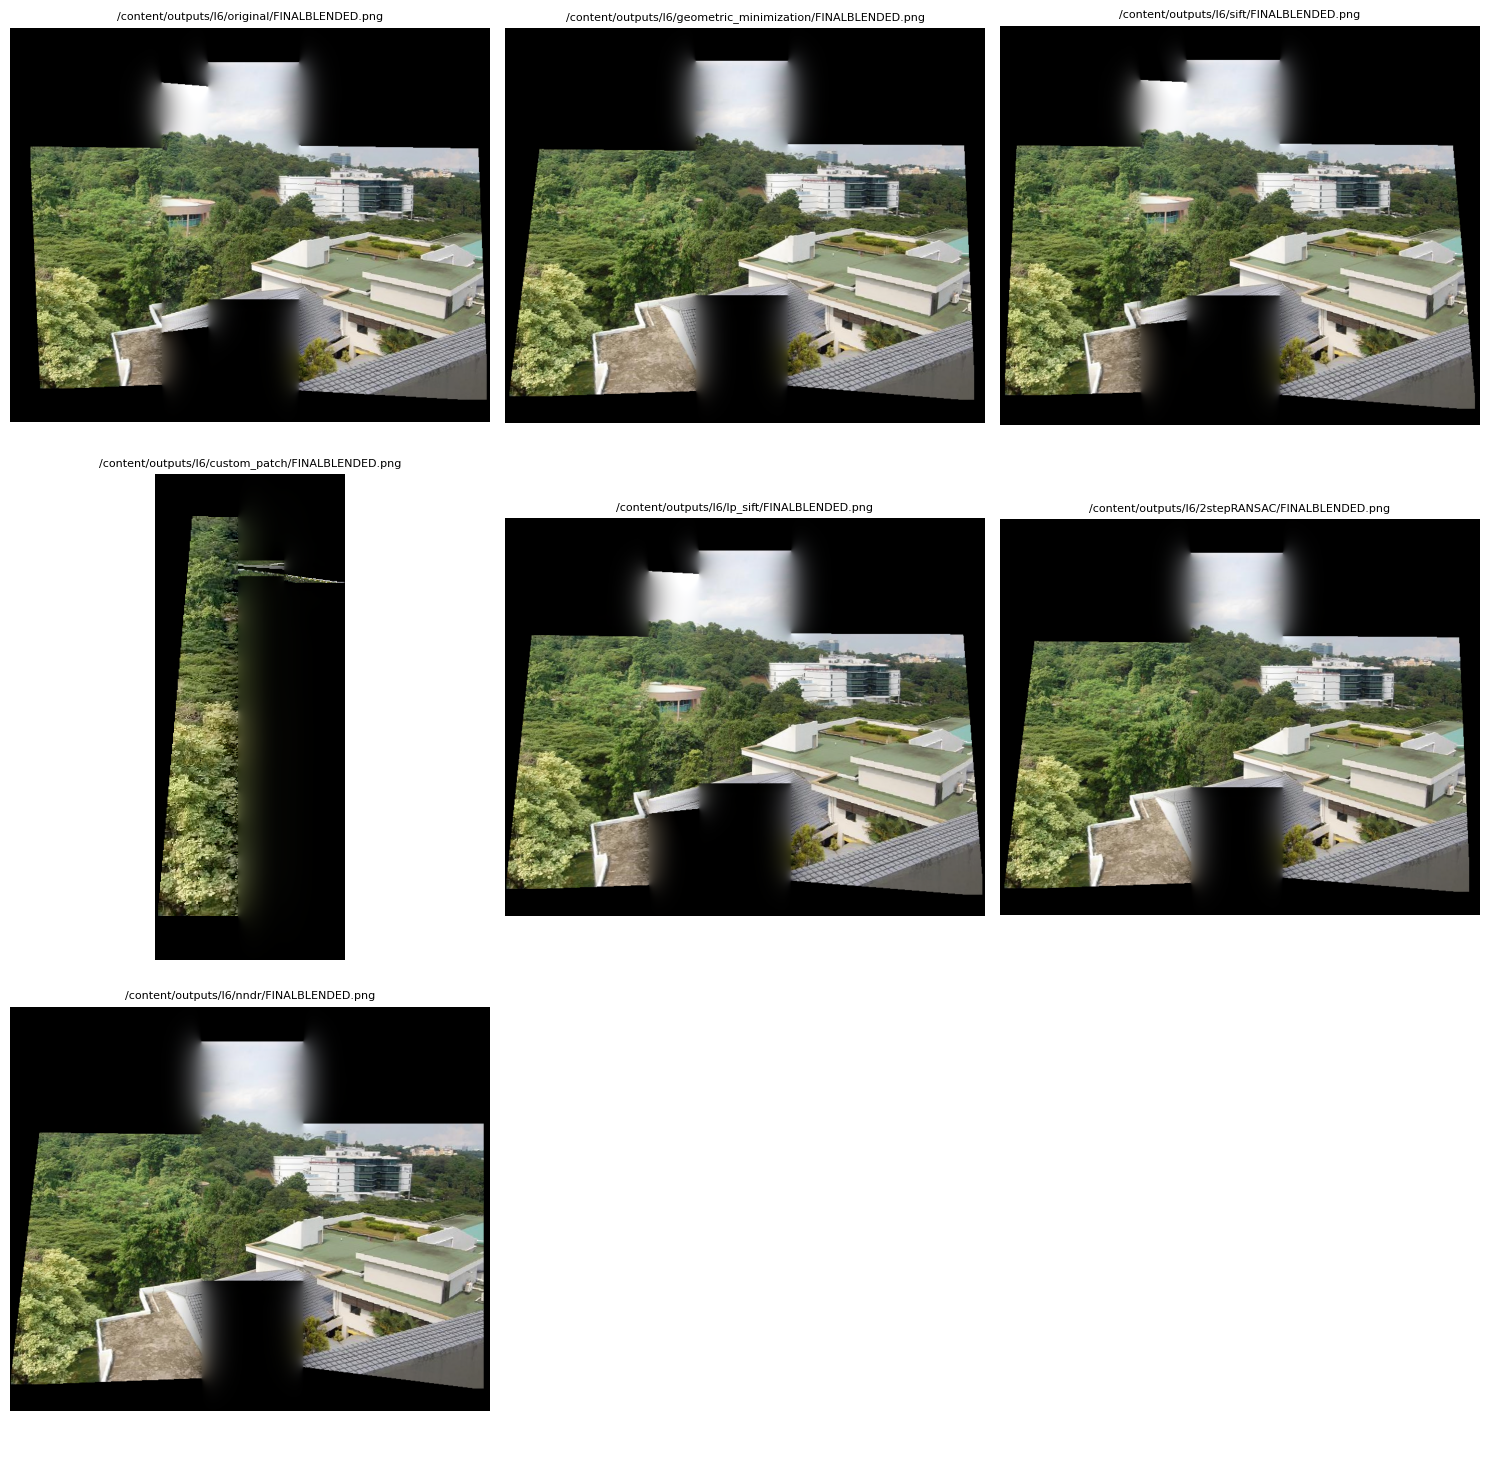

In [ ]:
image_paths = []
for file in os.listdir(base_dir):
    if not file.startswith("."):
        image_paths.append(base_dir + "/" + file + "/FINALBLENDED.png")
show_images_in_grid(image_paths)

In [ ]:
os.listdir("/content/outputs/I6")

['custom_patch',
 'nndr',
 'original',
 'lp_sift',
 '2stepRANSAC',
 'geometric_minimization',
 'sift']

In [ ]:
import cv2
import numpy as np
from skimage.filters import laplace
from skimage.measure import shannon_entropy
import pandas as pd

def compare(imageSet):
    stitched_images = []
    base = "/content/outputs/I" + str(imageSet)
    algorithms = os.listdir(base)
    for file in algorithms:
        if not file.startswith("."):
            stitched_images.append(cv2.imread(base + "/" + file + "/FINALBLENDED.png"))
    results = []

    def calculate_metrics(img):
        # Convert image to grayscale
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Entropy - Higher entropy generally indicates more detail
        entropy = shannon_entropy(gray_img)

        # Variance of Laplacian - Indicates sharpness of the image
        laplacian_var = cv2.Laplacian(gray_img, ddepth=cv2.CV_64F).var()

        # Completeness Score (using image overlap continuity)
        laplacian_img = laplace(gray_img)
        completeness = laplacian_img.var()  # Represents continuity in image gradient

        return {'Entropy': entropy, 'Sharpness (Laplacian Variance)': laplacian_var, 'Completeness': completeness}

    # Calculate metrics for each stitched image
    for i, image in enumerate(stitched_images):
        metrics = calculate_metrics(image)
        metrics['Algorithm'] = algorithms[i]
        results.append(metrics)

    # Create DataFrame from results
    df = pd.DataFrame(results)

    # Display the DataFrame
    print(df)

    # Find the best result based on the chosen metric, e.g., highest entropy
    best_result = df.loc[df['Entropy'].idxmax()]
    print(f"\nBest Result based on Entropy:\n{best_result}")


In [ ]:
compare(1)

    Entropy  Sharpness (Laplacian Variance)  Completeness  \
0  0.314684                       74.314555      0.001143   
1  0.177043                       45.716173      0.000703   
2  0.327095                       78.125384      0.001201   
3  0.352798                       78.837617      0.001212   
4  0.413864                       85.296561      0.001312   
5  0.247273                       60.469911      0.000930   
6  0.161542                       42.703431      0.000657   

                Algorithm  
0                original  
1  geometric_minimization  
2                    sift  
3            custom_patch  
4                 lp_sift  
5             2stepRANSAC  
6                    nndr  

Best Result based on Entropy:
Entropy                            0.413864
Sharpness (Laplacian Variance)    85.296561
Completeness                       0.001312
Algorithm                           lp_sift
Name: 4, dtype: object


In [ ]:
compare(4)

    Entropy  Sharpness (Laplacian Variance)  Completeness  \
0  0.408715                      175.015983      0.002692   
1  0.344685                      161.098955      0.002477   
2  0.343943                      163.589225      0.002516   
3  0.296030                      155.607659      0.002393   
4  0.365286                      167.205774      0.002571   
5  0.344685                      161.098955      0.002477   
6  0.318964                      156.453502      0.002406   

                Algorithm  
0                original  
1  geometric_minimization  
2                    sift  
3            custom_patch  
4                 lp_sift  
5             2stepRANSAC  
6                    nndr  

Best Result based on Entropy:
Entropy                             0.408715
Sharpness (Laplacian Variance)    175.015983
Completeness                        0.002692
Algorithm                           original
Name: 0, dtype: object


In [ ]:
compare(5)

    Entropy  Sharpness (Laplacian Variance)  Completeness  \
0  0.308287                       92.775150      0.001427   
1  0.262168                       85.696183      0.001318   
2  0.272399                       86.284634      0.001327   
3  0.132870                       39.358505      0.000605   
4  0.267753                       86.042165      0.001323   
5  0.256185                       84.957652      0.001307   
6  0.230877                       81.256305      0.001250   

                Algorithm  
0                original  
1  geometric_minimization  
2                    sift  
3            custom_patch  
4                 lp_sift  
5             2stepRANSAC  
6                    nndr  

Best Result based on Entropy:
Entropy                           0.308287
Sharpness (Laplacian Variance)    92.77515
Completeness                      0.001427
Algorithm                         original
Name: 0, dtype: object


In [ ]:
compare(6)

    Entropy  Sharpness (Laplacian Variance)  Completeness  \
0  0.167358                       39.361209      0.000605   
1  0.169553                       40.329365      0.000620   
2  0.174818                       39.814303      0.000612   
3  0.034501                        9.995249      0.000154   
4  0.177651                       40.383423      0.000621   
5  0.169553                       40.329365      0.000620   
6  0.170227                       40.321878      0.000620   

                Algorithm  
0                original  
1  geometric_minimization  
2                    sift  
3            custom_patch  
4                 lp_sift  
5             2stepRANSAC  
6                    nndr  

Best Result based on Entropy:
Entropy                            0.177651
Sharpness (Laplacian Variance)    40.383423
Completeness                       0.000621
Algorithm                           lp_sift
Name: 4, dtype: object
